In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import keras
random.seed(42)

%matplotlib inline

Using TensorFlow backend.


In [2]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

In [67]:
IMAGE_SIZE = (70, 70)

def process_image(image_location):
    image = cv2.imread(image_location)
    
    if image.shape[0] != IMAGE_SIZE[0] or image.shape[1] != IMAGE_SIZE[1]:
        # print("Resizing the image: {0}".format(image_location))
        resized_image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    else:
        resized_image = image
    
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    #denoised = cv2.fastNlMeansDenoising(gray,None)
    
    #print(denoised.shape)
    
    #hist_equalized = cv2.equalizeHist(denoised)
    edges = auto_canny(gray)
    print(edges.shape)
    
    
    # assert(denoised != edges)
    weighted_sum = cv2.addWeighted(gray, 0.8, edges, 0.2, 0)
       
    return weighted_sum

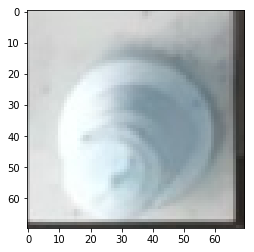

In [70]:
plt.imshow(cv2.imread("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\myboard_images\\w\\f_4.jpg"), cmap='gray')

(70, 70)


array([[166, 170, 170, ...,  57,  50,  47],
       [165, 170, 169, ...,  57,  50,  47],
       [164, 169, 168, ...,  56,  49,  46],
       ...,
       [183, 212, 167, ...,  34,  32,  30],
       [ 67,  82, 134, ...,  36,  35,  34],
       [ 45,  44,  42, ...,  53,  47,  42]], dtype=uint8)

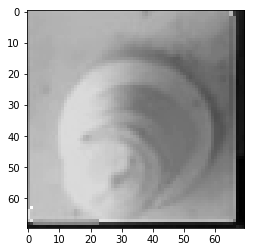

In [71]:
d = process_image("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\myboard_images\\w\\f_4.jpg")
plt.imshow(d, cmap='gray')
d.shape
d

In [ ]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    for fol in os.listdir(data_path):
        fol_path = os.path.join(data_path, fol)
        if os.path.isdir(fol_path):
            for file in os.listdir(fol_path):
                if ".jpg" in file:
                    label = -1

                    if fol[0] == "b":
                        label = 0
                    elif fol[0] == "w":
                        label = 1
                    elif fol == "empty":
                        label = 2

                    if label != -1:
                        complete_file_loc = os.path.join(fol_path, file)
                        grayscale_image = process_image(complete_file_loc)
                        grayscale_image = grayscale_image[..., np.newaxis]
                        features_with_labels.append({"feature": grayscale_image, "label": label})
            
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]
    
    X = np.array(X)
    X = X.astype('float32')
    X /= 255

    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\Chess ID Public Data\\train")
X_test, y_test = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\Chess ID Public Data\\test")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10360, 70, 70, 1)
(10360,)
(189, 70, 70, 1)
(189,)


In [ ]:
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import optimizers
from sklearn.metrics import confusion_matrix
from tensorflow import set_random_seed
set_random_seed(42)

In [ ]:
# batch size
batch_size = 64

# number of training epochs
epochs = 150

required_input_shape = (*IMAGE_SIZE, 1)

In [ ]:
model_folder_name = "models"
tensorboard_logs_folder_location = "logs"

In [ ]:
def train_3_class_cnn_model(X_train, Y_train, X_test, Y_test):
    """"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=required_input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.summary()

    # checkpoint
    if not os.path.exists(model_folder_name):
        os.makedirs(model_folder_name)
    
    # tensorboard logs
    if not os.path.exists(tensorboard_logs_folder_location):
        os.makedirs(tensorboard_logs_folder_location)
    
    filepath = os.path.join(model_folder_name, "custom_cnn.hdf5")
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=20, verbose=1, mode='max')
    
    tensorboard = TensorBoard(log_dir=tensorboard_logs_folder_location, histogram_freq=0, write_graph=True, write_images=True)
    
    callbacks_list = [checkpoint, earlystop, tensorboard]
    
    adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    hist = model.fit(X_train, Y_train, shuffle=True, batch_size=batch_size,
                     epochs=epochs, verbose=1,
                     validation_data=(X_test, Y_test), callbacks=callbacks_list)

    # Evaluating the model on the test data
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    return hist, model

In [ ]:
hist, model = train_3_class_cnn_model(X_train, y_train, X_test, y_test)

# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 68, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 68, 68, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

In [ ]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
class_names = ["black", "white", "empty"]
test_predictions = model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,title='Normalized confusion matrix')

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]

IMAGES_PER_ROW = 5

def plot_mispredicted_images(images, actual_values, predicted_values):
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    
    num_failed_images = len(mis_prediction_indices)
    num_images_per_row = IMAGES_PER_ROW
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)

    print(num_failed_images)
    print(num_rows)
    print(num_images_per_row)


    fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break

            axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]], cmap='gray')
            axes[itr, jtr].set_title("{0} predicted as {1}".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
            #print(current_image_idx)
            current_image_idx += 1

In [ ]:
test_images = np.squeeze(X_test)
print(test_images.shape)
plot_mispredicted_images(test_images, y_test, y_test_pred)

## Make predictions on actual board images

In [ ]:
X_test1, y_test1 = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\myboard_images")
test_predictions1 = model.predict(X_test1, batch_size=batch_size)
y_test_pred1 = [np.argmax(x) for x in test_predictions1]
cnf_matrix1 = confusion_matrix(y_test1, y_test_pred1)
plot_confusion_matrix(cnf_matrix1, classes=class_names, normalize=False,title='confusion matrix')